In [2]:
from utils import setup_env_path

setup_env_path()

Former working directory:  c:\Users\corne\Documents\2-Scolarite\1-AgroParisTech\4-Cursus\3-3A\5-Cours\14-Fil_Rouge\fil-rouge-pollinisateurs\notebooks
Current working directory:  c:\Users\corne\Documents\2-Scolarite\1-AgroParisTech\4-Cursus\3-3A\5-Cours\14-Fil_Rouge\fil-rouge-pollinisateurs


In [3]:
# Chargement des librairies
import pandas as pd
import matplotlib.pyplot as plt

# I. Préparation des données 

L'objectif est d'obtenir un dataset avec uniquement les colonnes insecte_sc et insecte_fr.  

De plus, toutes les lignes où il y a soit NA, soit "je ne sais pas", soit "autres" dans ces deux colonnes seront supprimées.

Une attention particulière ser apportée aux lignes possédant une valeur dans leur colonne insecte_fr mais pas dans insecte_sc. En effet, une analyse préliminaire a montré que ce cas existe pour exactement 12 valeurs de insecte_fr, qui sont :
- "Les Mouches difficiles à déterminer",
- "Les Coléoptères difficiles à déterminer",
- "Les Moustiques, Tipules et autres diptères Nématocères",
- "Les Chenilles et fausses-Chenilles",
- "Les Syrphes difficiles à déterminer",
- "Les Terebrants Chalcidiens et autres",
- "Les Epeires et autres Araneidae",
- "Les Punaises difficiles à déterminer",
- "Les Syrphes aux fémurs enflés",
- "Les Tachinaires difficiles à déterminer",
- "Les Punaises prédatrices ternes".  

Cette liste comprend des termes englobant des groupes assez larges d'insectes. Nous allons donc leur attribuer une valeur de insecte_sc qui pourra au mieux les englober d'après nos recherches et connaissances. Les *Punaises prédatrices ternes* n'ayant pas été identifié dans la littérature, nous les remplacerons par le nom scientifique des *Punaises ternes*.
- "Diptera", 
- "Coleoptera", 
- "Nematocera",
- "Lepidoptera", 
- "Syrphinae", 
- "Chalcidoidea",
- "Araneidae", 
- "Heteroptera", 
- "Syrphinae",
- "Tachinidae",
- "Lygus lineolaris".

Nous sélectionnerons les lignes où ces pairs insecte_sc/insecte_fr sont uniques.

## 1. Sélection des colonnes d'intérêt

In [3]:
# Import spipoll.csv as a pandas dataframe
spipoll = pd.read_csv("data/spipoll.csv", low_memory=False)

# Extract relevant columns from the spipoll dataframe
insect = spipoll[['insecte_sc', 'insecte_fr']]
insect.shape # (670744, 2)

(670744, 2)

## 2. Suppression des lignes sans information

In [4]:
values_to_check = ["Je ne sais pas", "Insecte inconnu"]

# Suppression des lignes ayant NA ou les values_to_check dans insecte_sc et dans insecte_fr
insect_no_info = insect.loc[
    (
        (insect["insecte_sc"].isna() | insect["insecte_sc"].isin(values_to_check)) &
        (insect["insecte_fr"].isna() | insect["insecte_fr"].isin(values_to_check))
    )
]
insect_no_info.shape # (11667, 2)

(11667, 2)

In [5]:
insect_no_info.head(30) # la sélection s'est bien passée si on retrouve des NA, "Je ne sais pas" et "Insecte inconnu"

,insecte_sc,insecte_fr
10,Insecte inconnu,Insecte inconnu
21,Insecte inconnu,Insecte inconnu
35,Insecte inconnu,Insecte inconnu
45,Insecte inconnu,Insecte inconnu
53,Insecte inconnu,Insecte inconnu
89,Insecte inconnu,Insecte inconnu
106,Insecte inconnu,Insecte inconnu
126,Insecte inconnu,Insecte inconnu
147,Insecte inconnu,Insecte inconnu
278,Insecte inconnu,Insecte inconnu


In [6]:
# Get the indices of the rows to be removed
indices_to_remove = insect_no_info.index

# Remove the rows
insect = insect.drop(indices_to_remove)
insect.shape # (659077, 2)

(659077, 2)

## 3. Suppression des doublons

In [7]:
# Duplicates deletion
insect = insect.drop_duplicates()
insect.shape # (577, 2)

(577, 2)

## 4. Enrichissement des données de colonne_sc

### A. Cas où insecte_sc est vide

In [8]:
# Complete the insecte_sc column with the insecte_fr column information
original = ["Les Mouches difficiles à déterminer",
            "Les Coléoptères difficiles à déterminer",
            "Les Moustiques, Tipules et autres diptères Nématocères",
            "Les Chenilles et fausses-Chenilles",
            "Les Syrphes difficiles à déterminer",
            "Les Terebrants Chalcidiens et autres",
            "Les Epeires et autres Araneidae",
            "Les Punaises difficiles à déterminer",
            "Les Syrphes aux fémurs enflés",
            "Les Tachinaires difficiles à déterminer",
            "Les Punaises prédatrices ternes"]
replacement = ["Diptera", "Coleoptera", "Nematocera",
               "Lepidoptera", "Syrphinae", "Chalcidoidea",
               "Araneidae", "Heteroptera", "Syrphinae",
               "Tachinidae", "Lygus lineolaris"]

def replace_insecte_sc(row):
    if pd.isna(row["insecte_sc"]) and row["insecte_fr"] in original:
        index = original.index(row["insecte_fr"])
        return replacement[index]
    else:
        return row["insecte_sc"]

insect["insecte_sc"] = insect.apply(replace_insecte_sc, axis=1)
insect.shape # (577, 2)

(577, 2)

In [9]:
insect.head(10) # la sélection s'est bien passée si on retrouve des valeurs remplacées

,insecte_sc,insecte_fr
0,Apis mellifera,L'Abeille mellifère
1,Bombus,Les Bourdons noirs à bande(s) jaune(s) et cul ...
3,Sarcophaga,Les Mouches à damier
5,Tettigonoidea,Les Sauterelles
6,"Neomyia, Calliphora et autres",Les Mouches aux reflets métalliques
7,Diptera,Les Mouches difficiles à déterminer
13,Tephritidae et autres,Les Téphritides et autres
16,"Eupeodes, Scaeva",Les Syrphes à taches en virgules
18,Episyrphus balteatus,Le Syrphe ceinturé
19,Meliscaeva et autres,Les Syrphes à abdomen fin


In [10]:
# Verification that the replacement happened on the whole dataset
insect['insecte_sc'].isna().sum() # 0

0

### B. Cas où insecte_sc est "autres"

In [11]:
# If insecte_sc is "autres", delete the value of insect_sc and keep the value of insect_fr
for i in range(len(insect)):
    if insect.iloc[i, 0] == "autres":
        insect.iloc[i, 0] = None

In [12]:
# Print the value of insecte_fr if insecte_sc is None
insect[insect["insecte_sc"].isna()]

,insecte_sc,insecte_fr
133,None,Les Araignées
891,None,Les Osmies
1701,None,Les Tenthrèdes
7989,None,Les Taupins


In [13]:
original = ["Les Araignées", "Les Osmies", "Les Tenthrèdes", "Les Taupins"]
replacement = ["Araneae", "Osmia", "Tenthredinidae", "Elateridae"]

insect["insecte_sc"] = insect.apply(replace_insecte_sc, axis=1)
insect.shape # (577, 2)

(577, 2)

## 5. Correction des fautes d'orthographe

In [14]:
# Ortograph correction
insect.replace("Tettigonoidea", "Tettigonioidea", inplace=True)
insect.replace("Sapigidae", "Sapygidae", inplace=True)
insect.replace("Aricias nicias", "Aricia nicias", inplace=True)

## 6. Enregistrement du dataset obtenu

In [15]:
len(insect["insecte_sc"].unique())

527

In [16]:
len(insect["insecte_fr"].unique())

577

In [17]:
# Save the insect dataframe to a csv file
insect.to_csv("data/insect/insect.csv", index=False)

# II. Classification des insectes (ITIS)

La classification ci-dessous est réalisée à l'aide de la **base de donnée de ITIS**. ITIS (Integrated Taxonomic Information System) est un programme dont l'objectif est de rassembler des données taxonomiques sur les plantes, les animaux, les champignons et autres micro-organismes.

Elle n'a **pas renvoyé de résultats assez satisfaisants** : sur les 527 valeurs uniques existantes dans la colonne *insecte_sc* du dataset spipoll ("autres" n'avaient pas été corrigé), seules 272 étaient identifiées. On ne pouvait donc pas obtenir la classification d'une moitié d'entre elles environ.

Une autre base de données a donc été utilisée pour réaliser la classification : celle du **NCBI**.

Ce notebook sera conservé pour les pré-traitements apportés au dataset initial nous permettant d'obtenir le document *insect.csv*. Il sera réutilisé dans le prochain notebook *insect_classification_ncbi.ipynb*.

In [ ]:
# import data_quality.insect_treatment.insect_classification_functions as classification_functions

In [18]:
# # Chargement du jeu de données
# df = pd.read_csv('data/insect/insect.csv')

In [19]:
# # Identification des espèces non présentes dans les databases de pytaxize
# unknown = classification_functions.find_unknown(df, 'insecte_sc')

In [20]:
# # Enregistrement des espèces inconnues
# unknown_df = pd.DataFrame(unknown, columns=['Unknown'])
# unknown_df.to_csv('data/insect/insects_unknown.csv', index=False)

In [21]:
# unknown = pd.read_csv('data/insect/insects_unknown.csv')
# unknown = unknown['Unknown'].tolist()
# unknown[:10]

In [22]:
# # Suppression des lignes contenant des noms non retrouvés 
# df = df[~df['insecte_sc'].isin(unknown)]
# len(df) # 309

In [23]:
# # Remplacement de certaines valeurs qui bloquent
# # Après avoir fait tourné le bloc ci-dessous
# df = df.replace('Stelis, Heriades', 'Heriades')
# df = df.replace('Ammophila, Hoplammophila', 'Hoplammophila')
# df = df.replace('Allantus, Macrophya et autres', 'Allantus')
# df = df.replace('Tibellus, Paratibellus', 'Tibellus')
# df = df.replace('Tenthredo, Rhogogaster', 'Tenthredo')
# df = df.replace('Nomioides, Celhalictus', 'Nomioides')

In [24]:
# len(df['insecte_sc'].unique()) # 275    

In [25]:
# classif = classification_functions.get_classification_df(df, 'insecte_sc')

In [26]:
# # Création des colonnes Ordre, Super famille, Famille, Sous famille, Genre, Espèce
# df['classification'] = df['insecte_sc'].apply(lambda x: classif[x] if x in classif else None)

# df['Ordre'] = df['classification'].apply(lambda x: x['Ordre'] if isinstance(x, dict) and 'Ordre' in x else None)
# df['Super famille'] = df['classification'].apply(lambda x: x['Super famille'] if isinstance(x, dict) and 'Super famille' in x else None)
# df['Famille'] = df['classification'].apply(lambda x: x['Famille'] if isinstance(x, dict) and 'Famille' in x else None)
# df['Sous famille'] = df['classification'].apply(lambda x: x['Sous famille'] if isinstance(x, dict) and 'Sous famille' in x else None)
# df['Genre'] = df['classification'].apply(lambda x: x['Genre'] if isinstance(x, dict) and 'Genre' in x else None)
# df['Espèce'] = df['classification'].apply(lambda x: x['Espèce'] if isinstance(x, dict) and 'Espèce' in x else None)

# df.head(30)

In [27]:
# # Enregistrement du nouveau dataframe
# df = df.rename(columns={'x': 'Insecte'})
# df_classif = df[['Insecte', 'Ordre', 'Super famille', 'Famille', 'Sous famille', 'Genre', 'Espèce']]
# df_classif.to_csv('data_insects/insect_classification_without_pp.csv', index=False)
# df_classif.head()

# III. Classification des insectes (NCBI)

In [4]:
import os
import warnings
from pytaxize.itis import hierarchy_full
from pytaxize.refactor import Refactor
from pytaxize import ncbi

os.environ['ENTREZ_KEY'] = "8c5e06834ba59d32554e4ee00d59a3a6e008"

In [29]:
# Les fonctions ci-dessous devraient être accessibles directement avec pytaxize
# Mais il y a des problèmes lors de l'importation
# Les recopier ici résoud ce problème 

def hierarchy(ids):
    """
    Get a full taxonomic hierarchy from NCBI

    :param ids: one or more NCBI taxonomy ids

    :note: Remember to set your Entrez API key as `ENTREZ_KEY`

    :return: dict, named with ids given to `ids`, 
        where each value in the dict is a list of taxa, each
        a dict with the fields ``ScientificName``, ``Rank``, and ``TaxId``

    Usage::

        from pytaxize import ncbi
        ncbi.hierarchy(ids=9606)
        ncbi.hierarchy(ids=[9606,55062,4231])
    """
    toget = ["ScientificName", "Rank", "TaxId"]
    key = os.environ.get("ENTREZ_KEY")
    if key is None:
        raise Exception("ENTREZ_KEY is not defined")
    if not isinstance(ids, list):
        ids = [ids]
    idz = ",".join([str(x) for x in ids])
    args = {"db": "taxonomy", "ID": idz, "api_key": key}
    res = _entrez("efetch", args)
    taxa = res.xpath("//TaxaSet/Taxon")
    out = []
    for x in range(len(taxa)):
        nodes = taxa[x].xpath(".//LineageEx/Taxon")
        tmp = [
            dict(zip(toget, [node.xpath(w)[0].text for w in toget])) for node in nodes
        ]
        tmp.append(dict(zip(toget, [taxa[x].xpath(w)[0].text for w in toget])))
        out.append(tmp)
    return dict(zip(ids, out))


class Classification(object):
    """
    Classification: Retrieve taxonomic hierarchy for taxonomic IDs

    Usage::

        from pytaxize import Classification
        
        # ITIS
        ## one id
        x = Classification(99208)
        x
        x.ids
        res = x.itis()
        res[99208]
        
        ## many ids - with one invalid id
        x = Classification([99208, 129313, 9999999])
        x
        x.ids
        res = x.itis()
        res[99208]
        res[129313]
        res[9999999]

        # NCBI
        x = Classification(9606)
        x
        x.ids
        x.ncbi()
    """

    def __init__(self, ids):
        if isinstance(ids, int):
            ids = [ids]
        self.ids = ids

    def __repr__(self):
        x = """<%s>\n""" % type(self).__name__
        y = """  ids: %s""" % ",".join([str(w) for w in self.ids[:10]])
        return x + y

    def itis(self):
        out = []
        for i in range(len(self.ids)):
            id = self.ids[i]
            res = hierarchy_full(id)
            if res[0] is None:
                warnings.warn("No results for taxon '" + str(id) + "'")
                res = {}
            out.append(res)
        out = dict(zip(self.ids, out))
        return out

    def ncbi(self):
        res = hierarchy(self.ids)
        # out = []
        # for i in range(len(self.ids)):
        #     id = self.ids[i]
            # if res[0] is None:
            #     warnings.warn("No results for taxon '" + str(id) + "'")
            #     res = {}
            # out.append(res)
        # out = dict(zip(self.ids, out))
        return res

def _entrez(path="esearch", args={}):
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/%s.fcgi" % path
    tt = Refactor(url, args, request="get").xml()
    return tt

## 1. Chargement des données

In [30]:
df = pd.read_csv('data/insect/insect.csv')

## 2. Classification des insectes

In [53]:
dictionary = {}
insect_unknown = []

def classification(insects_names):
    
    insect_error = []
            
    for insect in insects_names:
        
        # Cleaning of insects names
        insect_process = insect.replace(' et autres', '')          # on passe de 31 really unknown
        insect_process = insect_process.replace('plusieurs ', '')  # à ... avec ces deux commandes
        
        # Search if the insect is present in the ncbi database 
        search = ncbi.search(sci_com = insect_process)
        
        # If it is not present we put it in a list for ulterior treatment
        if len(search[insect_process]) == 0:
            insect_unknown.append(insect)
            print(search)
        
        # If it is present we search is classification
        else: 
            # Find the insect ID and have its classification
            id = int(search[insect_process][0]['TaxId'])
            x = Classification(id)
            x.ids
            try:
                classif = x.ncbi()
            except Exception as e:
                print("Une erreur s'est produite :", e)
                insect_error.append(insect)
            else:
                # Define the ranks we are interested in
                ranks = {'order': 'Ordre',
                        'superfamily': 'Super famille',
                        'family': 'Famille',
                        'subfamily': 'Sous famille',
                        'genus': 'Genre',
                        'species': 'Espèce'}
                # Extract the scientific names based on the rank
                names = {}
                for item in classif[id]:
                    if item['Rank'] in ranks.keys():
                        names[ranks[item['Rank']]] = item['ScientificName']
                dictionary[insect] = names
    return insect_error

insect_error = classification(df['insecte_sc'].unique())

Une erreur s'est produite : 400 Client Error: Bad Request for url: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=taxonomy&ID=7460&api_key=8c5e06834ba59d32554e4ee00d59a3a6e008
Une erreur s'est produite : 400 Client Error: Bad Request for url: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=taxonomy&ID=7148&api_key=8c5e06834ba59d32554e4ee00d59a3a6e008
{'cicadelles, cercopes': []}
Une erreur s'est produite : 400 Client Error: Bad Request for url: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=taxonomy&ID=94017&api_key=8c5e06834ba59d32554e4ee00d59a3a6e008
Une erreur s'est produite : 400 Client Error: Bad Request for url: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=taxonomy&ID=7088&api_key=8c5e06834ba59d32554e4ee00d59a3a6e008
Une erreur s'est produite : 400 Client Error: Bad Request for url: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=taxonomy&ID=116150&api_key=8c5e06834ba59d32554e4ee00d59a3a6e008
{'Aglais io': []}


### A. Traitement des valeurs ayant renvoyées des erreurs

Il est courant pour pytaxize de renvoyer une erreur (*Bad Request for url*). La même requête répétée permet en général d'obtenir la réponse attendue.

In [56]:
insect_error

['Apis mellifera',
 'Nematocera',
 'Salticidae',
 'Lepidoptera',
 'Pararge aegeria',
 'Stratiomys',
 'Formicidae',
 'Polyommatus et autres',
 'Conopidae',
 'Anthocharis cardamines',
 'Lygus lineolaris',
 'Trichodes alvearius',
 'Meloe',
 'Grammoptera et autres',
 'Cimbicidae',
 'Tropidothorax leucopterus',
 'Acmaeops et autres',
 'Trichodes leucopsideus',
 'Megalodontes',
 'Pseudopanthera macularia',
 'Mylabris et autres',
 'Graphosoma semipunctatum',
 'Sceliphron caementarium',
 'Maculinea',
 'Pyrochroa coccinea',
 'Abia fasciata',
 'Eupithecia et autres',
 'Thanatus',
 'Chorosoma schillingii',
 'Conophorus',
 'Melanargia occitanica',
 'Setina aurita',
 'Quercusia quercus',
 'Deilephila porcellus']

In [59]:
while len(insect_error) > 0:
    insect_error = classification(insect_error)
    print(insect_error)

[]


In [60]:
print(len(dictionary))
print(len(insect_unknown)) # 2 times Dasytidae
print(len(df['insecte_sc'].unique()))

509
18
527


### B. Traitement des valeurs inconnues

Il y a peu de valeurs inconnues (18) en utilisant la base de donnée du NCBI plutôt que celle de ITIS.

Nous n'avons cependant plus aucun moyen d'obtenir la classification de ces insectes de manière automatique. 

Nous pouvons essayer d'obtenir leur classification par une revue de la littérature ([site de l'INPN](https://inpn.mnhn.fr/accueil/recherche-de-donnees/especes/), Inventaire National du Patrimoine Naturel), mais ce n'est pas idéal.

In [61]:
insect_unknown

['cicadelles, cercopes et autres',
 'Aglais io',
 'Tibellus, Paratibellus',
 'plusieurs Dasytidae',
 'Polyommatus, Plebeius et autres',
 'Nomioides, Celhalictus',
 'Bibio hortulanus',
 'Opsilia coerulescens',
 'Bombylella atra',
 'Glaphyra et autres',
 'Hoplia coerulea',
 'Hemipenthes maura',
 'Hemipenthes velutina',
 'Usia',
 'Vadonia unipunctata',
 'Chlorophorus pilosus',
 'Eclimus gracilis',
 'Oberea erythrocephala']

In [63]:
dictionary['cicadelles, cercopes et autres'] = {'Ordre': 'Hemiptera'}
dictionary['Aglais io'] = {'Ordre': 'Lepidoptera', 'Super famille': 'Papilionoidea', 'Famille': 'Nymphalidae', 'Sous famille': 'Nymphalinae', 'Genre': 'Aglais', 'Espèce': 'Aglais io'}
dictionary['Tibellus, Paratibellus'] = {'Ordre': 'Araneae', 'Super famille': 'Araneoidea', 'Famille': 'Philodromidae'}
dictionary['plusieurs Dasytidae'] = {'Ordre': 'Coleoptera', 'Super famille': 'Cleroidea', 'Famille': 'Melyridae'}
dictionary['Polyommatus, Plebeius et autres'] = {'Ordre': 'Lepidoptera', 'Super famille': 'Papilionoidea', 'Famille': 'Lycaenidae'}
dictionary['Nomioides, Celhalictus'] = {'Ordre': 'Hymenoptera', 'Super famille': 'Apoidea', 'Famille': 'Halictidae'}
dictionary['Bibio hortulanus'] = {'Ordre': 'Diptera', 'Super famille': 'Bibionoidea', 'Famille': 'Bibionidae', 'Sous famille': 'Bibioninae', 'Genre': 'Bibio', 'Espèce': 'Bibio hortulanus'}
dictionary['Opsilia coerulescens'] = {'Ordre': 'Coleoptera', 'Super famille': 'Chrysomeloidea', 'Famille': 'Cerambycidae', 'Sous famille': 'Lamiinae', 'Genre': 'Opsilia', 'Espèce': 'Opsilia coerulescens'}
dictionary['Bombylella atra'] = {'Ordre': 'Diptera', 'Super famille': 'Asiloidea', 'Famille': 'Bombyliidae', 'Genre': 'Bombylella', 'Espèce': 'Bombylella atra'}
dictionary['Glaphyra et autres'] = {'Ordre': 'Coleoptera', 'Super famille': 'Chrysomeloidea', 'Famille': 'Cerambycidae', 'Sous famille': 'Cerambycinae', 'Genre': 'Glaphyra'}
dictionary['Hoplia coerulea'] = {'Ordre': 'Coleoptera', 'Super famille': 'Scarabaeoidea', 'Famille': 'Scarabaeidea', 'Sous famille': 'Melolonthinae','Genre': 'Hoplia', 'Espèce': 'Hoplia coerulea'}
dictionary['Hemipenthes maura'] = {'Ordre': 'Diptera', 'Super famille': 'Asiloidea', 'Famille': 'Bombyliidae', 'Genre': 'Hemipenthes', 'Espèce': 'Hemipenthes maura'}
dictionary['Hemipenthes velutina'] = {'Ordre': 'Diptera', 'Super famille': 'Asiloidea', 'Famille': 'Bombyliidae', 'Genre': 'Hemipenthes', 'Espèce': 'Hemipenthes velutina'}
dictionary['Usia'] = {'Ordre': 'Diptera', 'Super famille': 'Asiloidea', 'Famille': 'Bombyliidae', 'Genre': 'Usia'}
dictionary['Vadonia unipunctata'] = {'Ordre': 'Coleoptera', 'Super famille': 'Chrysomeloidea', 'Famille': 'Cerambycidae', 'Sous famille': 'Lepturinae', 'Genre': 'Vadonia', 'Espèce': 'Vadonia unipunctata'}
dictionary['Chlorophorus pilosus'] = {'Ordre': 'Coleoptera', 'Super famille': 'Chrysomeloidea', 'Famille': 'Cerambycidae', 'Sous famille': 'Cerambycinae', 'Genre': 'Chlorophorus', 'Espèce': 'Chlorophorus pilosus'}
dictionary['Eclimus gracilis'] = {'Ordre': 'Diptera', 'Super famille': 'Asiloidea', 'Famille': 'Bombyliidae', 'Genre': 'Eclimus', 'Espèce': 'Eclimus gracilis'}
dictionary['Oberea erythrocephala'] = {'Ordre': 'Coleoptera', 'Super famille': 'Chrysomeloidea', 'Famille': 'Cerambycidae', 'Sous famille': 'Lamiinae', 'Genre': 'Oberea', 'Espèce': 'Oberea erythrocephala'}

In [64]:
print(len(dictionary))
print(len(df['insecte_sc'].unique()))

527
527


## 3. Enregistrement de la classification de chaque valeur unique de insecte_sc

In [65]:
with pd.option_context('mode.chained_assignment', None):
    # Création des colonnes Ordre, Super famille, Famille, Sous famille, Genre, Espèce
    df['classification'] = df['insecte_sc'].apply(lambda x: dictionary[x] if x in dictionary else None)

    df['Ordre'] = df['classification'].apply(lambda x: x['Ordre'] if isinstance(x, dict) and 'Ordre' in x else None)
    df['Super famille'] = df['classification'].apply(lambda x: x['Super famille'] if isinstance(x, dict) and 'Super famille' in x else None)
    df['Famille'] = df['classification'].apply(lambda x: x['Famille'] if isinstance(x, dict) and 'Famille' in x else None)
    df['Sous famille'] = df['classification'].apply(lambda x: x['Sous famille'] if isinstance(x, dict) and 'Sous famille' in x else None)
    df['Genre'] = df['classification'].apply(lambda x: x['Genre'] if isinstance(x, dict) and 'Genre' in x else None)
    df['Espèce'] = df['classification'].apply(lambda x: x['Espèce'] if isinstance(x, dict) and 'Espèce' in x else None)

    df.drop(columns=['classification'], inplace=True)

In [66]:
df.head(10)

,insecte_sc,insecte_fr,Ordre,Super famille,Famille,Sous famille,Genre,Espèce
0,Apis mellifera,L'Abeille mellifère,Hymenoptera,Apoidea,Apidae,Apinae,Apis,Apis mellifera
1,Bombus,Les Bourdons noirs à bande(s) jaune(s) et cul ...,Hymenoptera,Apoidea,Apidae,Apinae,Bombus,None
2,Sarcophaga,Les Mouches à damier,Diptera,Oestroidea,Sarcophagidae,Sarcophaginae,Sarcophaga,None
3,Tettigonioidea,Les Sauterelles,Orthoptera,Tettigonioidea,None,None,None,None
4,"Neomyia, Calliphora et autres",Les Mouches aux reflets métalliques,Diptera,Oestroidea,Calliphoridae,Calliphorinae,Calliphora,None
5,Diptera,Les Mouches difficiles à déterminer,Diptera,None,None,None,None,None
6,Tephritidae et autres,Les Téphritides et autres,Diptera,Tephritoidea,Tephritidae,None,None,None
7,"Eupeodes, Scaeva",Les Syrphes à taches en virgules,Diptera,Syrphoidea,Syrphidae,Syrphinae,Scaeva,None
8,Episyrphus balteatus,Le Syrphe ceinturé,Diptera,Syrphoidea,Syrphidae,Syrphinae,Episyrphus,Episyrphus balteatus
9,Meliscaeva et autres,Les Syrphes à abdomen fin,Diptera,Syrphoidea,Syrphidae,Syrphinae,Meliscaeva,None


In [67]:
df.to_csv('data/insect/insect_classif_unique.csv', index=False)

## 4. Enregistrement de la classification de toutes les lignes 

In [8]:
df_unique = pd.read_csv('data/insect/insect_classif_unique.csv')

In [10]:
# Import spipoll.csv as a pandas dataframe
spipoll = pd.read_csv("data/spipoll.csv", low_memory=False)

# Extract relevant columns from the spipoll dataframe
df_collection = spipoll[['collection_id', 'insecte_sc', 'insecte_fr']]
df_collection.shape # (670744, 3)

(670744, 3)

In [11]:
merged_df = pd.merge(df_collection, df_unique, on='insecte_fr', how='left')
merged_df.shape # (670744, 9)

(670744, 10)

In [12]:
merged_df.head(10)

,collection_id,insecte_sc_x,insecte_fr,insecte_sc_y,Ordre,Super famille,Famille,Sous famille,Genre,Espèce
0,1,Apis mellifera,L'Abeille mellifère,Apis mellifera,Hymenoptera,Apoidea,Apidae,Apinae,Apis,Apis mellifera
1,1,Bombus,Les Bourdons noirs à bande(s) jaune(s) et cul ...,Bombus,Hymenoptera,Apoidea,Apidae,Apinae,Bombus,NaN
2,2,Bombus,Les Bourdons noirs à bande(s) jaune(s) et cul ...,Bombus,Hymenoptera,Apoidea,Apidae,Apinae,Bombus,NaN
3,2,Sarcophaga,Les Mouches à damier,Sarcophaga,Diptera,Oestroidea,Sarcophagidae,Sarcophaginae,Sarcophaga,NaN
4,2,Apis mellifera,L'Abeille mellifère,Apis mellifera,Hymenoptera,Apoidea,Apidae,Apinae,Apis,Apis mellifera
5,3,Tettigonoidea,Les Sauterelles,Tettigonioidea,Orthoptera,Tettigonioidea,NaN,NaN,NaN,NaN
6,4,"Neomyia, Calliphora et autres",Les Mouches aux reflets métalliques,"Neomyia, Calliphora et autres",Diptera,Oestroidea,Calliphoridae,Calliphorinae,Calliphora,NaN
7,4,NaN,Les Mouches difficiles à déterminer,Diptera,Diptera,NaN,NaN,NaN,NaN,NaN
8,4,Apis mellifera,L'Abeille mellifère,Apis mellifera,Hymenoptera,Apoidea,Apidae,Apinae,Apis,Apis mellifera
9,4,NaN,Les Mouches difficiles à déterminer,Diptera,Diptera,NaN,NaN,NaN,NaN,NaN


In [13]:
merged_df.rename(columns={'insecte_sc_x': 'insecte_sc'}, inplace=True)
merged_df.drop(columns=['insecte_sc_y'], inplace=True)

In [14]:
merged_df.head(10)

,collection_id,insecte_sc,insecte_fr,Ordre,Super famille,Famille,Sous famille,Genre,Espèce
0,1,Apis mellifera,L'Abeille mellifère,Hymenoptera,Apoidea,Apidae,Apinae,Apis,Apis mellifera
1,1,Bombus,Les Bourdons noirs à bande(s) jaune(s) et cul ...,Hymenoptera,Apoidea,Apidae,Apinae,Bombus,NaN
2,2,Bombus,Les Bourdons noirs à bande(s) jaune(s) et cul ...,Hymenoptera,Apoidea,Apidae,Apinae,Bombus,NaN
3,2,Sarcophaga,Les Mouches à damier,Diptera,Oestroidea,Sarcophagidae,Sarcophaginae,Sarcophaga,NaN
4,2,Apis mellifera,L'Abeille mellifère,Hymenoptera,Apoidea,Apidae,Apinae,Apis,Apis mellifera
5,3,Tettigonoidea,Les Sauterelles,Orthoptera,Tettigonioidea,NaN,NaN,NaN,NaN
6,4,"Neomyia, Calliphora et autres",Les Mouches aux reflets métalliques,Diptera,Oestroidea,Calliphoridae,Calliphorinae,Calliphora,NaN
7,4,NaN,Les Mouches difficiles à déterminer,Diptera,NaN,NaN,NaN,NaN,NaN
8,4,Apis mellifera,L'Abeille mellifère,Hymenoptera,Apoidea,Apidae,Apinae,Apis,Apis mellifera
9,4,NaN,Les Mouches difficiles à déterminer,Diptera,NaN,NaN,NaN,NaN,NaN


In [15]:
merged_df.to_csv('data/insect/insect_classif.csv', index=False)

## 5. Visualisation des données obtenues

In [4]:
merged_df = pd.read_csv('data/insect/insect_classif.csv')

In [5]:
count_df = {}
length = len(merged_df) 
col_name = []

for column in merged_df.columns[1:]:
    count_df[column] = length - merged_df[column].isna().sum()
    col_name.append(column)
count_df

{'insecte_sc': 580508,
 'insecte_fr': 665339,
 'Ordre': 658914,
 'Super famille': 555788,
 'Famille': 569404,
 'Sous famille': 405615,
 'Genre': 426862,
 'Espèce': 125540}

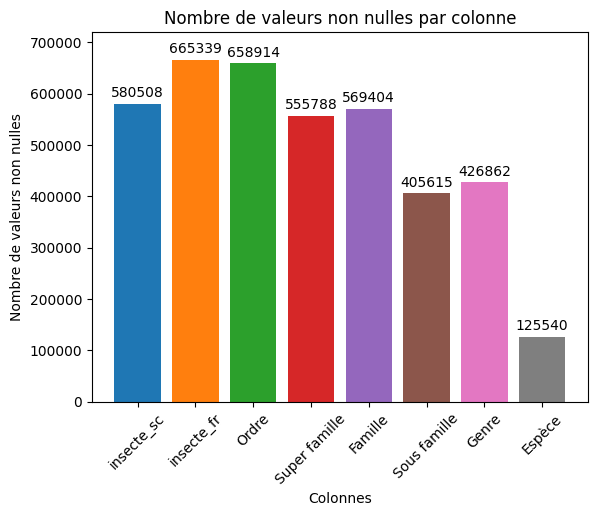

In [6]:
fig, ax = plt.subplots()

for col, value in count_df.items():
    p = ax.bar(col, value, label=value)
    ax.bar_label(p, padding=3)

ax.set_title('Nombre de valeurs non nulles par colonne')
ax.set_xlabel('Colonnes')
ax.set_xticks(col_name)
ax.set_xticklabels([i for i in col_name], rotation=45)
ax.set_ylabel('Nombre de valeurs non nulles')
ax.set_ylim(0, 720000)

plt.show()

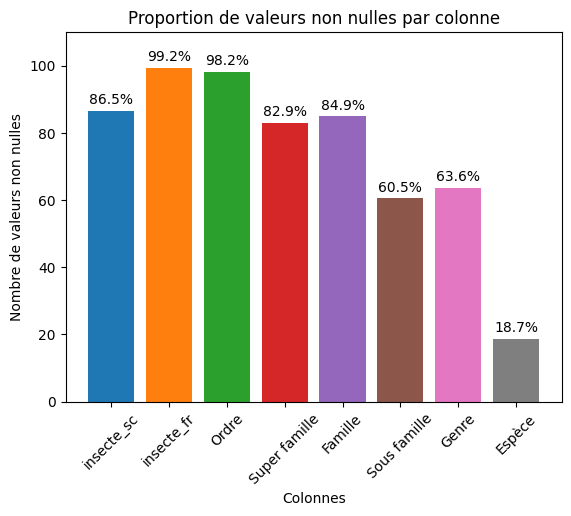

In [7]:
fig, ax = plt.subplots()

for col, value in count_df.items():
    p = ax.bar(col, value/length*100, label=value)
    ax.bar_label(p, fmt=lambda x: '%g%%' % round(x, 1), padding=3)

ax.set_title('Proportion de valeurs non nulles par colonne')
ax.set_xlabel('Colonnes')
ax.set_xticks(col_name)
ax.set_xticklabels([i for i in col_name], rotation=45)
ax.set_ylabel('Nombre de valeurs non nulles')
ax.set_ylim(0, 110)

plt.show()

<Axes: >

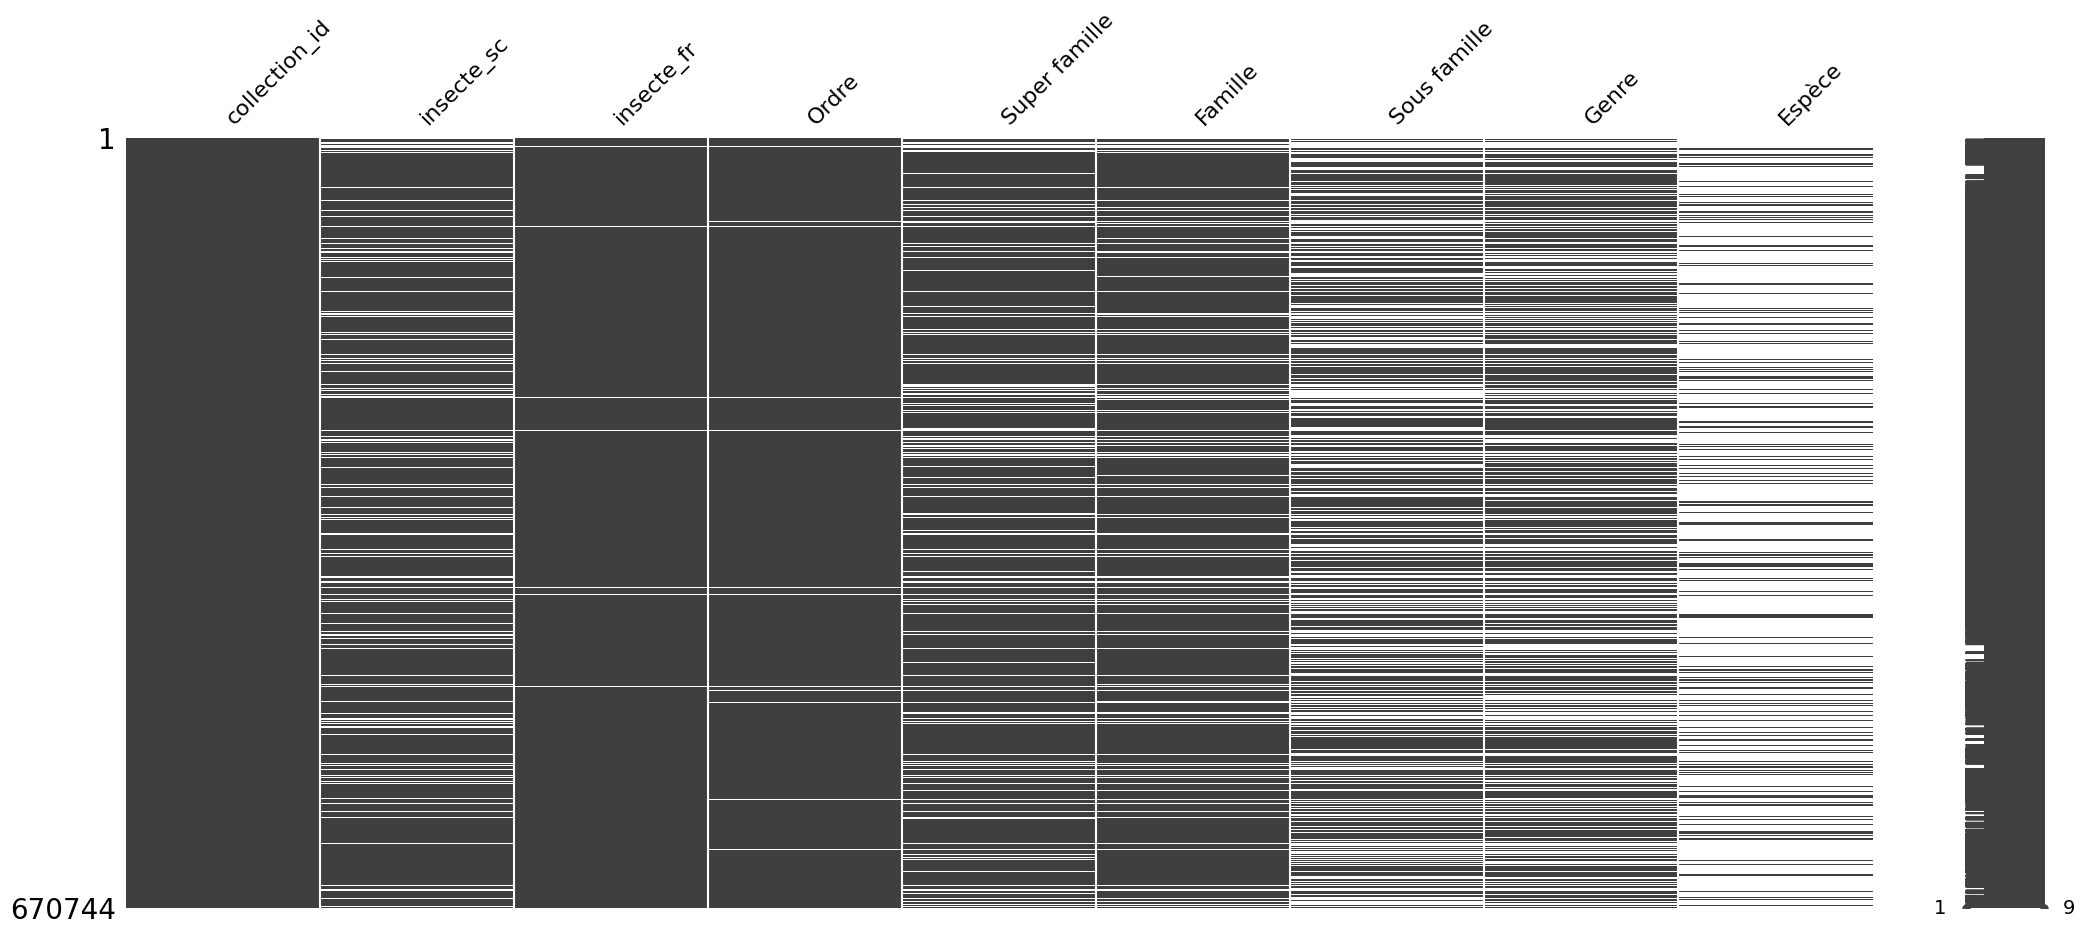

In [8]:
import missingno as msno

msno.matrix(merged_df)

In [12]:
number_unique = {}

for col in merged_df.columns[1:]:
    number_unique[col] = len(merged_df[col].unique()) - 1 # -1 to remove the NaN value

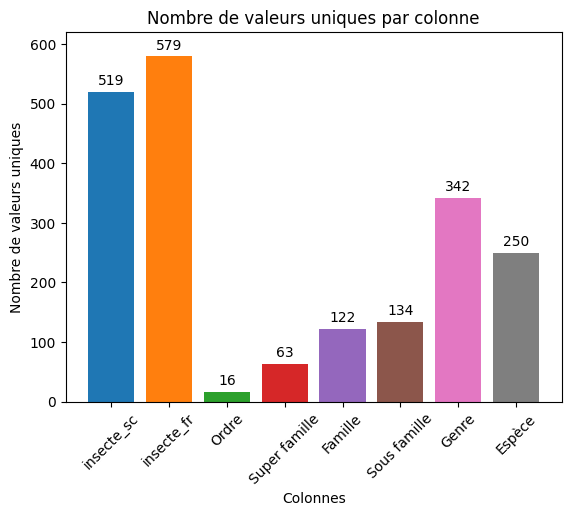

In [13]:
fig, ax = plt.subplots()

for col, value in number_unique.items():
    p = ax.bar(col, value, label=value)
    ax.bar_label(p, padding=3)

ax.set_title('Nombre de valeurs uniques par colonne')
ax.set_xlabel('Colonnes')
ax.set_xticks(col_name)
ax.set_xticklabels([i for i in col_name], rotation=45)
ax.set_ylabel('Nombre de valeurs uniques')
ax.set_ylim(0, 620)

plt.show()